In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from datetime import datetime
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [2]:
x = np.random.randn(100000)

# Benchmark parameters
* Size of the input data vector: $10^5$
* Size of the kernels: $1$ to $2^{13}$ (8192)
* Number of tests: 100
* Number of warmup iterations: 100

In [3]:
def alloc_xh(N):
    return x, np.ones(N) / N

def benchmark(label, func, prealloc = alloc_xh, warmup = True):
    M     = 13  # log(2) of the kernel size
    T     = 100 # Number of tests
    sizes = 2 ** np.arange(M)
    td    = np.zeros([M, T])
    xhs   = []
    y     = np.zeros([M, len(x)])
    
    tic = datetime.now()
    for i in range(len(sizes)):
        N = sizes[i]
        R = prealloc(N)
        xhs.append(R)
    tac = datetime.now()

    ts  = (tac - tic).microseconds
    print(fr'Moving average precalculation ({label}): {ts * 1e-3:.3g} ms')
    
    print('N = ', end = '')
    
    for i in range(len(sizes)):
        N = sizes[i]
        print(fr'{N}, ', end = '')

        if warmup:
            for j in range(T):
                tic = datetime.now()
                y[i, :] += func(*xhs[i]) / N
                tac = datetime.now()
                td[i, j] = (tac - tic).microseconds
            
        for j in range(T):
            tic = datetime.now()
            y[i, :] += func(*xhs[i]) / N
            tac = datetime.now()
            td[i, j] = (tac - tic).microseconds
    print('done')
    
    mean = np.mean(td, axis = 1)
    mmax = np.max(td, axis = 1)
    mmin = np.min(td, axis = 1)
    eTop = mmax - mean
    eBot = mean - mmin
    err  = np.array([eBot, eTop])
    plt.scatter(sizes, mean * 1e-3, label = label)
    plt.errorbar(sizes,mean * 1e-3, yerr=err * 1e-3, capsize=3, elinewidth=1, markeredgewidth=1, linewidth = 0)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which = 'major')
    plt.grid(which = 'minor', linestyle = 'dashed', linewidth = .5)
    plt.xlabel('Moving average size')
    plt.ylabel('Calculation time [ms]')
    
    plt.xscale('log')
    plt.ylim([0, plt.gca().get_ylim()[1]])
    plt.xlim([sizes[0], sizes[-1]])
    plt.title(label)
    return y

## Explicit moving average
This is based on `np.convolve`. It literally implements the following formula:

\begin{equation}
    y[n] = (x * h)[n] = \sum_{\tau = 0}^{N - 1} x[n - \tau]h[\tau]
\end{equation}

With $h$ a convolution kernel of size $N$ and all coefficients set to $1/N$. This is an $O(mn)$ operation. You have to traverse all points in $x$ times all points in $h$ in order to get your result.

Moving average precalculation (NumPy's convolve): 0.257 ms
N = 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, done


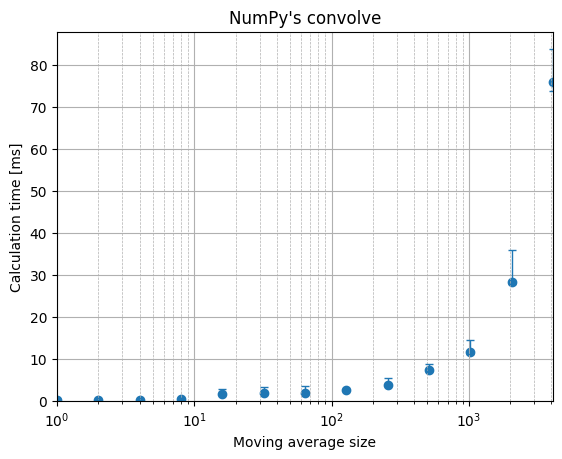

In [4]:
yNp = benchmark("NumPy's convolve", lambda x, h: np.convolve(x, h, 'same'))

## FFT moving average
This is based on `scipy.signal.fftconvolve`. It calculates the same quantity as `np.convolve` by leveraging an interesting property of convolutions and the Fast Fourier Transform algorithm.

Let $x$ and $h$ be your input data and convolution kernel, as described previously. The latter is padded with zeros to match the size of $x$. Now, let us define:

\begin{align}
\hat X &= \mathcal F[x]\\
\hat H &= \mathcal F[h]\\
\end{align}

With $\mathcal F$ the discrete Fourier transform (DFT). The convolution theorem states that:

$$
\mathcal F[x * h] = \mathcal F[x]\mathcal F[h]
$$

With $\mathcal F^{-1}$ the inverse discrete Fourier transform (DFT), which is defined as:

$$
\hat{X}[k] = \sum_{i = 0}^{M-1}x[i] \text{exp}\left[-j\frac {2\pi k} M i\right]
$$

We could implement our moving average as:

$$
 \implies y = \mathcal F^{-1}[\hat X\hat H]
$$

Seems more convoluted, right? (pun intended). It definitely seems so: if you take the theory literally, this is a $O(n^2)$ operation, as for each element in $y$ we need to traverse a number of frequencies equal to the size of the input array.

**However**, it turns out the DFT implemented using the so-called fast Fourier transform algorithm (which is $O(n\text{ log }n)$). This means that, for big $n$, it beats the original DFT implementation. This is basically what `fftconvolve` does: computes the FFT size of `x` and `h`, multiples them and calculates its inverse.

Moving average precalculation (SciPy's fftconvolve): 0.516 ms
N = 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, done


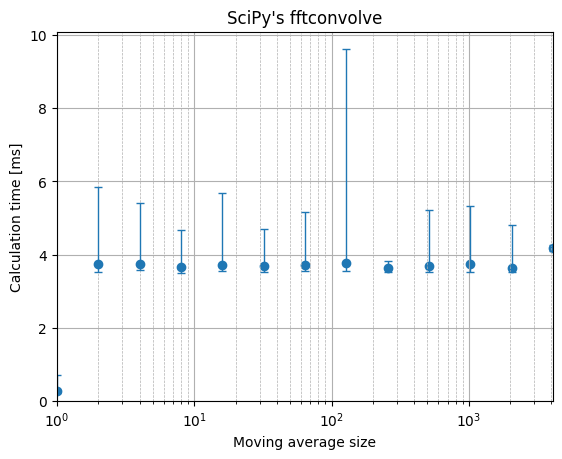

In [5]:
ySci = benchmark("SciPy's fftconvolve", lambda x, h: fftconvolve(x, h, 'same'))

## Precalculating the FFT of the convolution kernel

In some cases, we are going to perform the same moving average to different data. For each call to `fftconvolve`, the same FFT of `h` is being calculated, which is a bit of a waste. We could precalculate the FFT for `h` once, and reuse it for filtering in the frequency domain, thus saving 1/3 of the FFT (IFFT) calls in subsequent calculations.

There are some caveats to take into account though: it is usually said about the DFT that it is the "Fourier Transform on a circle". Indeed, it is equivalent to discretizing a continuous function in a sequence of Diract deltas, and making it periodic up to $N$ deltas (resulting in the discrete spectrum we all know and love). This means that, if you apply this technique directly, you are actually going to filter a curve with both ends "glued" together: the values in the first coefficients are going to affect the values in the last ones and vice-versa.

`fftconvolve` does two extra steps here that we should replicate the same results and performance:

* It adds a padding to prevent the effects caused by the periodicity of the signal (or, more precisely, to account for the fact that a signal that is $M$ in length convolved by a kernel that is $N$ in length is $M + N - 1$ coefficients long).
* It adds an extra padding to align (i.e. round up) its size to a power of 2, as the FFT is considerably faster under this configuration.

The resulting code looks like this:

Moving average precalculation (Kernel FFT precalculation): 109 ms
N = 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, done


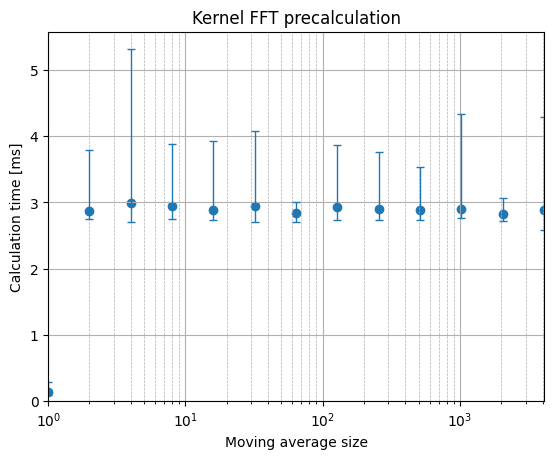

In [6]:
MAXPAD = len(x) // 2
Xjws   = []

Xjw    = np.fft.fft(np.pad(x, MAXPAD))

def fft_alloc_xh(N):
    minPad = N // 2 + 1
    minSize = len(x) + 2 * minPad
    logSize = int(np.ceil(np.log2(minSize)))
    desSize = 2 ** logSize
    pad     = (desSize - len(x)) // 2
    
    if N == 1:
        pad = 0
        Xjw = np.fft.fft(x)
        Hjw = np.ones(Xjw.shape, dtype = 'complex')
    else:
        Xjw = np.fft.fft(np.pad(x, pad))
        hn      = np.zeros(Xjw.shape, dtype = 'complex')
        hn[0:N] = 1 / N
        hn[N:]  = 0
        Hjw = np.fft.fft(np.roll(hn, 1 - N//2))
    return Xjw, Hjw, pad

def do_filter(Xjw, Hjw, pad):
    if pad == 0:
        return x
    else:
        return np.real(np.fft.ifft(Xjw * Hjw)[pad:-pad])
    
yFFT = benchmark("Kernel FFT precalculation", do_filter, prealloc = fft_alloc_xh)

Moving average precalculation (NumPy's convolve): 0.2 ms
N = 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, done
Moving average precalculation (SciPy's fftconvolve): 0.119 ms
N = 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, done
Moving average precalculation (Kernel FFT precalculation): 101 ms
N = 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, done


Text(0.5, 1.0, 'All techniques')

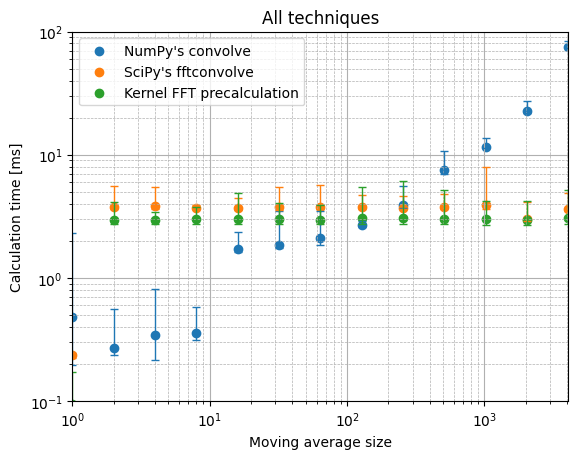

In [9]:
benchmark("NumPy's convolve", lambda x, h: np.convolve(x, h, 'same'))
benchmark("SciPy's fftconvolve", lambda x, h: fftconvolve(x, h, 'same'))
benchmark("Kernel FFT precalculation", do_filter, prealloc = fft_alloc_xh)

plt.yscale('log')
plt.ylim([0.1, 100])
plt.legend()
plt.title('All techniques')

In [10]:
maxAbsESciNp  = np.max(np.abs(ySci.T - yNp.T))
maxAbsESciFFT = np.max(np.abs(ySci.T - yFFT.T))
maxAbsENpFFT  = np.max(np.abs(yFFT.T - yNp.T))

print(fr'Max discrepancy (SciPy vs NumPy): {maxAbsESciNp:.2g}')
print(fr'Max discrepancy (SciPy vs FFT):   {maxAbsESciFFT:.2g}')
print(fr'Max discrepancy (NumPy vs FFT):   {maxAbsENpFFT:.2g}')

Max discrepancy (SciPy vs NumPy): 2.6e-12
Max discrepancy (SciPy vs FFT):   2.4e-12
Max discrepancy (NumPy vs FFT):   2.6e-12


# Take home message
- `np.convlve` is slow for big ($N > 200$) kernels. Don't use it if you are averaging lots of samples.
- `np.fftconvolve` is good and provides a generally flat computation time for a fixed signal length and a convolution kernel up to the size of the signal.
- FFT precalculation is better, but not much better (25% speed up increase, give or take), and it is also more convoluted. Use it only if you are struggling to speed up stuff (e.g. your calculations take hours to complete)